## Assignment 6
----

### Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Functions / Classes
-----

In [3]:
def Clenshaw_Curtis(M, domain = [-1, 1]):
    """
    Calculates M + 1 Clenshaw-Curtis nodes on the specified interval
    NOTE give values 2**n for sequence of n = 1,2,... for nested nodes of lecture slides
    """
    nodes = []
    dom_len = domain[1]-domain[0]
    dom_shift = domain[0]

    nodes = dom_len/2*(np.cos(np.arange(M+1)*np.pi/M) + 1) + domain[0]
    
    return nodes



def Lagrange(Z, Z_vals, k):
    """
    Lagrange k-th polynomial in the point Z and given points Z_val
    """
    res = 1

    for Z_i in Z_vals:
        if Z_i == Z_vals[k]:
            continue
        res *= (Z - Z_i)/(Z_vals[k] - Z_i)

    return res

def residual(w, N, kappa, dx, boundary):
    """
    Residual used in Newton method
    """
    res_val = []

    for k in range(N):
        # boundary cases
        if k == 0:
            res_val.append(w[k] - boundary[0])
        elif k == N-1:
            res_val.append(w[k] - boundary[1])

        # other case
        else:
            res_val.append((w[k+1]**2-w[k-1]**2)/(4*dx) - kappa*(w[k+1]-2*w[k] + w[k-1])/(dx**2))

    return res_val

def System_solver(N, domain, boundary, kappa, steps = 100):
    """
    Newton solver for Burgers equation
    """
    matrix_construct = 0

    # init function guess -> line between boundary conditions
    w = np.linspace(boundary[0], boundary[1], N)
    dx = (domain[1]-domain[0])/(N-1)

    Jacobian = np.zeros((N,N))
    step = 0
    while step < steps:
        # get update of residual values
        res_value = residual(w, N, kappa, dx, boundary)

        # get update of Jacobian
        for i in range(N):
            # boundary cases
            if i == 0 or i == N-1:
                Jacobian[i][i] = 1
            else:
                Jacobian[i][i] = 2*kappa/(dx**2)
                Jacobian[i][i-1] = -w[i-1]/(2*dx) - kappa/(dx**2)
                Jacobian[i][i+1] = w[i+1]/(2*dx) - kappa/(dx**2)
    

        # get Newton update
        dw = np.linalg.solve(Jacobian, res_value)

        # update estimate
        w = w - dw

        # increment step count
        step += 1

    return w

### TESTS - Ignore
-------

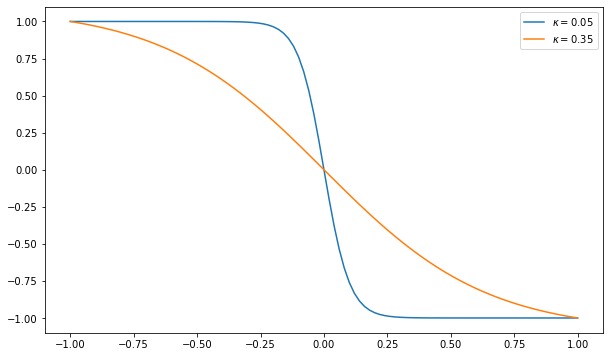

In [4]:
# test for newton solver
N = 101
a = System_solver(N, [-1, 1], [1, -1], 0.05)
b = System_solver(N, [-1, 1], [1, -1], 0.35)

plt.figure(figsize=(10,6))
plt.plot(np.linspace(-1, 1, N), a, label='$\kappa = 0.05$');
plt.plot(np.linspace(-1, 1, N), b, label='$\kappa = 0.35$');

plt.legend();

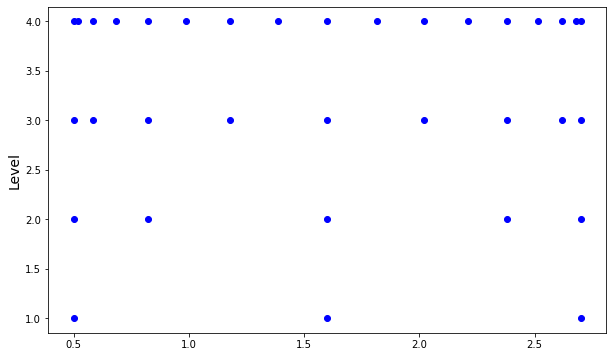

In [5]:
# Clenshaw Curtis nodes test
plt.figure(figsize=(10,6))
plt.ylabel('Level', fontsize=14)
for M in range(1, 5):
    nodes = Clenshaw_Curtis(2**M, domain=[.5, 2.7])
    y = [M]*(2**M+1)
    plt.plot(nodes, y, 'bo');

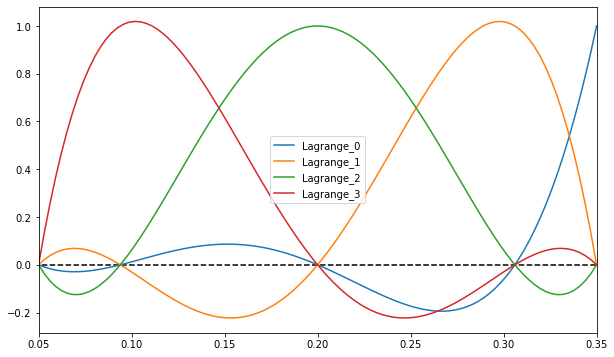

In [6]:
# Lagrange polynomial test
M = 4

Z_vals = Clenshaw_Curtis(M, [0.05, 0.35])

results = [[] for i in range(M)]
for k in range(M):
    x_vals = np.linspace(0.05, 0.35, 100)
    for Z in x_vals:
        results[k].append(Lagrange(Z, Z_vals, k))

plt.figure(figsize=(10,6))
plt.xlim(0.05, 0.35)
plt.hlines(0, -1, 1, color='black', ls='--');
for k in range(M):
    plt.plot(x_vals, results[k], label=f'Lagrange_{k}');

plt.legend();